# Churn prediction

**Description**

Customer churn is also known as customer turnover, or customer attrition, is the loss of clients or customers.

Telephone service companies, Internet service providers, pay TV companies, insurance firms, and alarm monitoring services, often use customer attrition analysis and customer attrition rates as one of their key business metrics because the cost of retaining an existing customer is far less than acquiring a new one. Companies from these sectors often have customer service branches which attempt to win back defecting clients, because recovered long-term customers can be worth much more to a company than newly recruited clients.

Predictive analytics use churn prediction models that predict customer churn by assessing their propensity of risk to churn. Since these models generate a small prioritized list of potential defectors, they are effective at focusing customer retention marketing programs on the subset of the customer base who are most vulnerable to churn.

Data is taken from https://www.kaggle.com/puja19/telcom-customer-churn

## Table of contents
0. [Loading data](#load)
1. [Exploratory analysis](#eda)
2. [Skewness](#skew)
3. [PCA](#pca)
4. [Churn Prediction](#ml)  
    4.1 [Random Forest](#rf)

In [586]:
import os
import pandas as pd
import numpy as np
import pandas_profiling
import pylab
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from category_encoders import CountEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, recall_score, precision_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

## 0. Loading data <a id=load>

In [6]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [2]:
data = pd.read_csv(os.path.join('Telco-Customer-Churn.csv'))

In [7]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [10]:
# There are no missing values in the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [8]:
# Correcting columns values
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float64')

In [9]:
#Changing datatypes
data['TotalCharges'] = data['TotalCharges'].astype('float64')
data['SeniorCitizen'] = data['SeniorCitizen'].astype('category')

In [10]:
data['SeniorCitizen'].replace({0: 'No', 1:'Yes'}, inplace = True)

In [11]:
# Checking unique categorical values
categoricals = data.select_dtypes('object')
for i in categoricals.drop(['Churn', 'customerID'], axis = 1).columns:
        print('Unique values for variable %s: %s:' %(i, data[i].unique()))

Unique values for variable gender: ['Female' 'Male']:
Unique values for variable SeniorCitizen: ['No' 'Yes']:
Unique values for variable Partner: ['Yes' 'No']:
Unique values for variable Dependents: ['No' 'Yes']:
Unique values for variable PhoneService: ['No' 'Yes']:
Unique values for variable MultipleLines: ['No phone service' 'No' 'Yes']:
Unique values for variable InternetService: ['DSL' 'Fiber optic' 'No']:
Unique values for variable OnlineSecurity: ['No' 'Yes' 'No internet service']:
Unique values for variable OnlineBackup: ['Yes' 'No' 'No internet service']:
Unique values for variable DeviceProtection: ['No' 'Yes' 'No internet service']:
Unique values for variable TechSupport: ['No' 'Yes' 'No internet service']:
Unique values for variable StreamingTV: ['No' 'Yes' 'No internet service']:
Unique values for variable StreamingMovies: ['No' 'Yes' 'No internet service']:
Unique values for variable Contract: ['Month-to-month' 'One year' 'Two year']:
Unique values for variable PaperlessB

In [12]:
# Changing all the rest object types:
for i in categoricals:
    data[i]=data[i].astype('category')

In [54]:
#Number of uniques
data.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

In [55]:
#Final check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null category
gender              7043 non-null category
SeniorCitizen       7043 non-null category
Partner             7043 non-null category
Dependents          7043 non-null category
tenure              7043 non-null int64
PhoneService        7043 non-null category
MultipleLines       7043 non-null category
InternetService     7043 non-null category
OnlineSecurity      7043 non-null category
OnlineBackup        7043 non-null category
DeviceProtection    7043 non-null category
TechSupport         7043 non-null category
StreamingTV         7043 non-null category
StreamingMovies     7043 non-null category
Contract            7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
Churn               7043 non-null cate

# 1. Exploratory analysis <a id=eda>

Since our goal is to predict churn, first lets look at the ratio of customers who churned and who didn't:

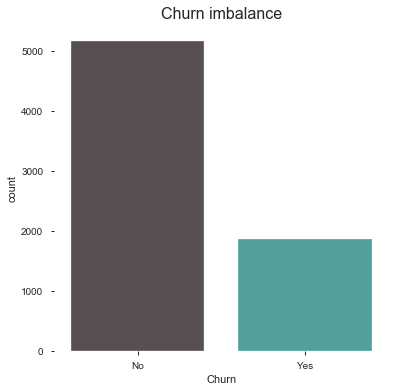

In [293]:
fig = plt.figure(figsize = (6,6))
sns.set_style('ticks')
a = sns.countplot(data['Churn'], palette = ['#594F4F', '#45ADA8'])
a.set_title('Churn imbalance', fontsize = 16);

In [314]:
print('Total class imbalance is: %s %% negative labels to %s %% positive ones. So 1 in 4 customers leaves us.' %(round(sum(data.Churn == 'Yes')*100/len(data.Churn),2), 
                                                round(sum(data.Churn == 'No')*100/len(data.Churn == 'Yes'),2)))

Total class imbalance is: 26.54 % negative labels to 73.46 % positive ones. So 1 in 4 customers leaves us.


Let's take a look at the factors that impact churn.

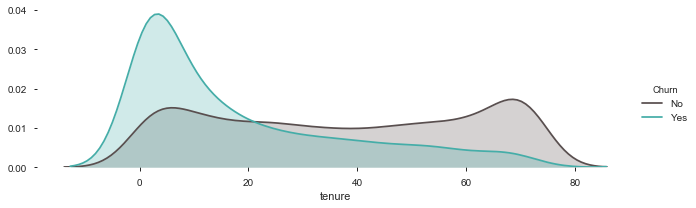

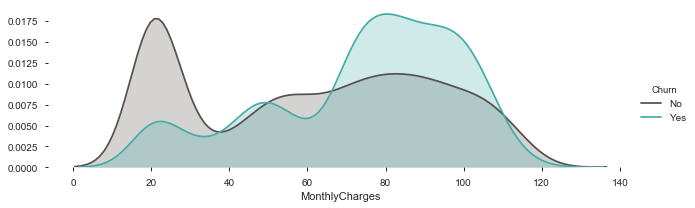

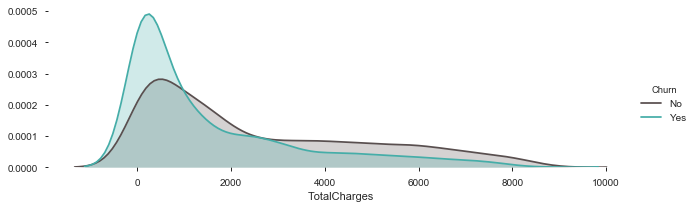

In [292]:
#Exporing individually numerical variables

for col in data.select_dtypes(np.number):
    g = sns.FacetGrid(data, hue="Churn", palette = ['#594F4F', '#45ADA8'], aspect = 3 )
    g.map(sns.kdeplot, col, shade = True)
    g.add_legend()

As we can see **numerical variables alone cannot capture the division between churn classes fully**, although the outliers tend to belong to one specific class, especially in Monthly Charges and tenure.

The majority of people who leave have very low Total Charges which may imply that **we're loosing a lot of customers on early stages**. There are a lot of **people who leave us because of high Monthly Charges** as well. A lot of **people who churn have low tenure**
.

Now, let's take a look at our categorical variables that emphasize the groups of our clients based on different attributes. For churn analysis it's crucial to consider two points:
- **The size of the targeted group**;
- **Propensity to churn within the group**. 


Knowing those features we can prioritize our marketing actions in order to achieve the best efficiency given certain cost on retaining the clients. If we find that customers belonging to a particular demographic or other group tend to churn more, we should first target the big groups with the higher propensity to churn and only then spend the rest of the marketing budget on small groups of our clients that leave us.

Now, **let's look into demographic aspect of our customer base**.

**Gender**

In [310]:
print('Total number of customers by gender:')
data['gender'].value_counts()

Total number of customers by gender:


Male      3555
Female    3488
Name: gender, dtype: int64

In [347]:
data.groupby(['Churn', 'gender'])['Churn'].count()

Churn  gender
No     Female    2549
       Male      2625
Yes    Female     939
       Male       930
Name: Churn, dtype: int64

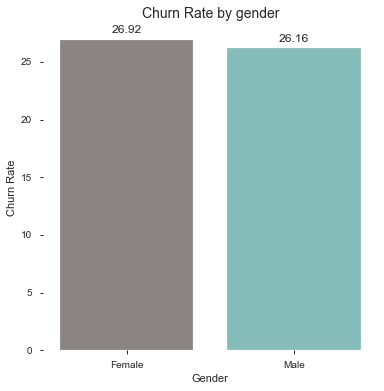

In [350]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['gender'].value_counts()*100/data['gender'].value_counts(),2), 
                 x = data['gender'].unique(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by gender', fontsize = 14)
ax.set(xlabel='Gender', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**Churn doesn't seem to differ between gender**, neither in absolute, nor relative values(percentage of churned clients).

**Senior citizenship**

In [308]:
print('Total number of customers by seniority:')
data['SeniorCitizen'].value_counts()

Total number of customers by seniority:


No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

In [251]:
#Number of sinior clients:
print('There are %s %% senior clients in the database.' % round(sum(data['SeniorCitizen'] == 'Yes')*100/data.shape[0],2))

There are 16.21 % senior clients in the database.


In [346]:
data.groupby(['Churn', 'SeniorCitizen'])['Churn'].count()

Churn  SeniorCitizen
No     No               4508
       Yes               666
Yes    No               1393
       Yes               476
Name: Churn, dtype: int64

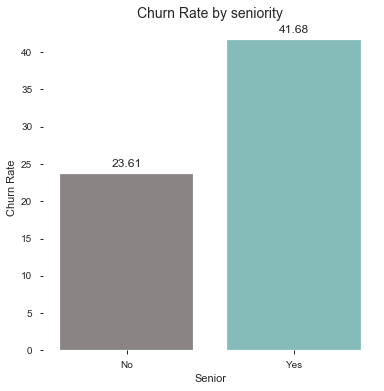

In [352]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['SeniorCitizen'].value_counts()*100/data['SeniorCitizen'].value_counts(),2), 
                 x = data['SeniorCitizen'].unique(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by seniority', fontsize = 14)
ax.set(xlabel='Senior', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

We can see that there are a **few senior customers in our business**. However, they seem to have a **significantly higher churn rate** (41.68% compared to only 23.61% amongst non senior citizens). But, given the fact that they comprise only 16% of all clients they should not be priority for marketing actions.

**Partner**

In [307]:
print('Total number of customers by partner:')
data['Partner'].value_counts()

Total number of customers by partner:


No     3641
Yes    3402
Name: Partner, dtype: int64

In [354]:
data.groupby(['Partner', 'Churn',])['Churn'].count()

Partner  Churn
No       No       2441
         Yes      1200
Yes      No       2733
         Yes       669
Name: Churn, dtype: int64

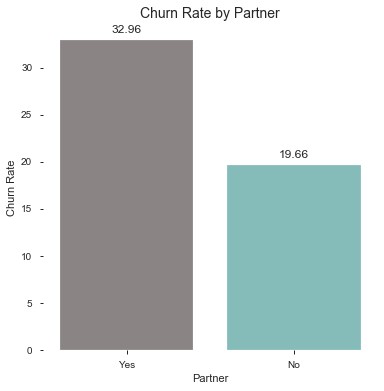

In [353]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['Partner'].value_counts()*100/data['Partner'].value_counts(),2), 
                 x = data['Partner'].unique(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Partner', fontsize = 14)
ax.set(xlabel='Partner', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**People with a partner seem to churn more than people without**. Given that it refers to 50% of our customers, we should be careful about that.

**Dependents**

In [358]:
print('Total number of customers by Dependents:')
data['Dependents'].value_counts()

Total number of customers by Dependents:


No     4933
Yes    2110
Name: Dependents, dtype: int64

In [359]:
#Number of clients with dependents:
print('There are %s %% clients with dependents in the database.' % round(sum(data['Dependents'] == 'Yes')*100/data.shape[0],2))

There are 29.96 % clients with dependents in the database.


In [360]:
data.groupby(['Dependents', 'Churn',])['Churn'].count()

Dependents  Churn
No          No       3390
            Yes      1543
Yes         No       1784
            Yes       326
Name: Churn, dtype: int64

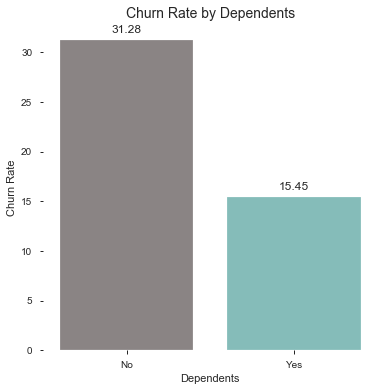

In [361]:
fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(y = round(data[data['Churn'] == 'Yes']['Dependents'].value_counts()*100/data['Dependents'].value_counts(),2), 
                 x = data['Dependents'].unique(), palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Dependents', fontsize = 14)
ax.set(xlabel='Dependents', ylabel='Churn Rate')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
        p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize = 12);

**People without dependents tend to churn twice as much as people with them**. The majority of our clients don't have any dependents, so their are in the risk group!

**Demographics in total**

Since gender didn't seem to have any impact let's combine all other factors together:

In [369]:
print('Total number of people in the group:')
data.groupby(['Dependents', 'Partner', "SeniorCitizen"])["SeniorCitizen"].count()

Total number of people in the group:


Dependents  Partner  SeniorCitizen
No          No       No               2719
                     Yes               561
            Yes      No               1163
                     Yes               490
Yes         No       No                353
                     Yes                 8
            Yes      No               1666
                     Yes                83
Name: SeniorCitizen, dtype: int64

In [421]:
# Churn rates by groups
round(data[data['Churn'] == 'Yes'].groupby(['Dependents', 'Partner', 
                "SeniorCitizen"])['Dependents'].count()*100/data.groupby(['Dependents', 'Partner', "SeniorCitizen"])['Dependents'].count(),2)

Dependents  Partner  SeniorCitizen
No          No       No               31.15
                     Yes              49.20
            Yes      No               20.81
                     Yes              36.33
Yes         No       No               21.25
                     Yes              25.00
            Yes      No               13.75
                     Yes              24.10
Name: Dependents, dtype: float64

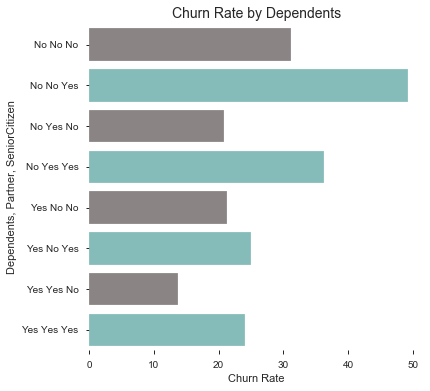

In [419]:
y_axis = ['No No No',
'No No Yes',
'No Yes No',
'No Yes Yes',
'Yes No No',
'Yes No Yes',
'Yes Yes No',
'Yes Yes Yes']

fig = plt.gcf()
fig.set_size_inches(6, 6)

ax = sns.barplot(x = round(data[data['Churn'] == 'Yes'].groupby(['Dependents', 'Partner', 
                "SeniorCitizen"])['Dependents'].count()*100/data.groupby(['Dependents', 'Partner', "SeniorCitizen"])['Dependents'].count(),2), 
                  y = y_axis,palette = ['#594F4F', '#45ADA8'], alpha = 0.7)
ax.set_title('Churn Rate by Dependents', fontsize = 14)
ax.set(xlabel='Churn Rate', ylabel='Dependents, Partner, SeniorCitizen');

The **least churning group is young people with dependets and a partner** - 13.75%; **the most - seniors without dependents and partner** - 49.20%. However, this group accounts for only 561 people, which is only 8% of all customers, so it's not that fatal for business. The most concerning group is young people  without dependents and a partner who account for 38% of the clients and who's churn rate is 31.15%.

**Other categoricals**

Finally, let's take a look at people grouped by other attributes.

In [426]:
data.groupby(['PhoneService', 'Churn',])['Churn'].count()

PhoneService  Churn
No            No        512
              Yes       170
Yes           No       4662
              Yes      1699
Name: Churn, dtype: int64

In [428]:
data.groupby(['MultipleLines', 'Churn',])['Churn'].count()

MultipleLines     Churn
No                No       2541
                  Yes       849
No phone service  No        512
                  Yes       170
Yes               No       2121
                  Yes       850
Name: Churn, dtype: int64

In [429]:
data.groupby(['InternetService', 'Churn',])['Churn'].count()

InternetService  Churn
DSL              No       1962
                 Yes       459
Fiber optic      No       1799
                 Yes      1297
No               No       1413
                 Yes       113
Name: Churn, dtype: int64

In [430]:
data.groupby(['OnlineSecurity', 'Churn',])['Churn'].count()

OnlineSecurity       Churn
No                   No       2037
                     Yes      1461
No internet service  No       1413
                     Yes       113
Yes                  No       1724
                     Yes       295
Name: Churn, dtype: int64

In [431]:
data.groupby(['OnlineBackup', 'Churn',])['Churn'].count()

OnlineBackup         Churn
No                   No       1855
                     Yes      1233
No internet service  No       1413
                     Yes       113
Yes                  No       1906
                     Yes       523
Name: Churn, dtype: int64

In [432]:
data.groupby(['DeviceProtection', 'Churn',])['Churn'].count()

DeviceProtection     Churn
No                   No       1884
                     Yes      1211
No internet service  No       1413
                     Yes       113
Yes                  No       1877
                     Yes       545
Name: Churn, dtype: int64

In [435]:
data.groupby(['TechSupport', 'Churn',])['Churn'].count()

TechSupport          Churn
No                   No       2027
                     Yes      1446
No internet service  No       1413
                     Yes       113
Yes                  No       1734
                     Yes       310
Name: Churn, dtype: int64

In [436]:
data.groupby(['StreamingTV', 'Churn',])['Churn'].count()

StreamingTV          Churn
No                   No       1868
                     Yes       942
No internet service  No       1413
                     Yes       113
Yes                  No       1893
                     Yes       814
Name: Churn, dtype: int64

In [437]:
data.groupby(['StreamingMovies', 'Churn',])['Churn'].count()

StreamingMovies      Churn
No                   No       1847
                     Yes       938
No internet service  No       1413
                     Yes       113
Yes                  No       1914
                     Yes       818
Name: Churn, dtype: int64

In [438]:
data.groupby(['Contract', 'Churn',])['Churn'].count()

Contract        Churn
Month-to-month  No       2220
                Yes      1655
One year        No       1307
                Yes       166
Two year        No       1647
                Yes        48
Name: Churn, dtype: int64

In [439]:
data.groupby(['PaperlessBilling', 'Churn',])['Churn'].count()

PaperlessBilling  Churn
No                No       2403
                  Yes       469
Yes               No       2771
                  Yes      1400
Name: Churn, dtype: int64

In [440]:
data.groupby(['PaymentMethod', 'Churn',])['Churn'].count()

PaymentMethod              Churn
Bank transfer (automatic)  No       1286
                           Yes       258
Credit card (automatic)    No       1290
                           Yes       232
Electronic check           No       1294
                           Yes      1071
Mailed check               No       1304
                           Yes       308
Name: Churn, dtype: int64

Churn Rate by various attributes: 



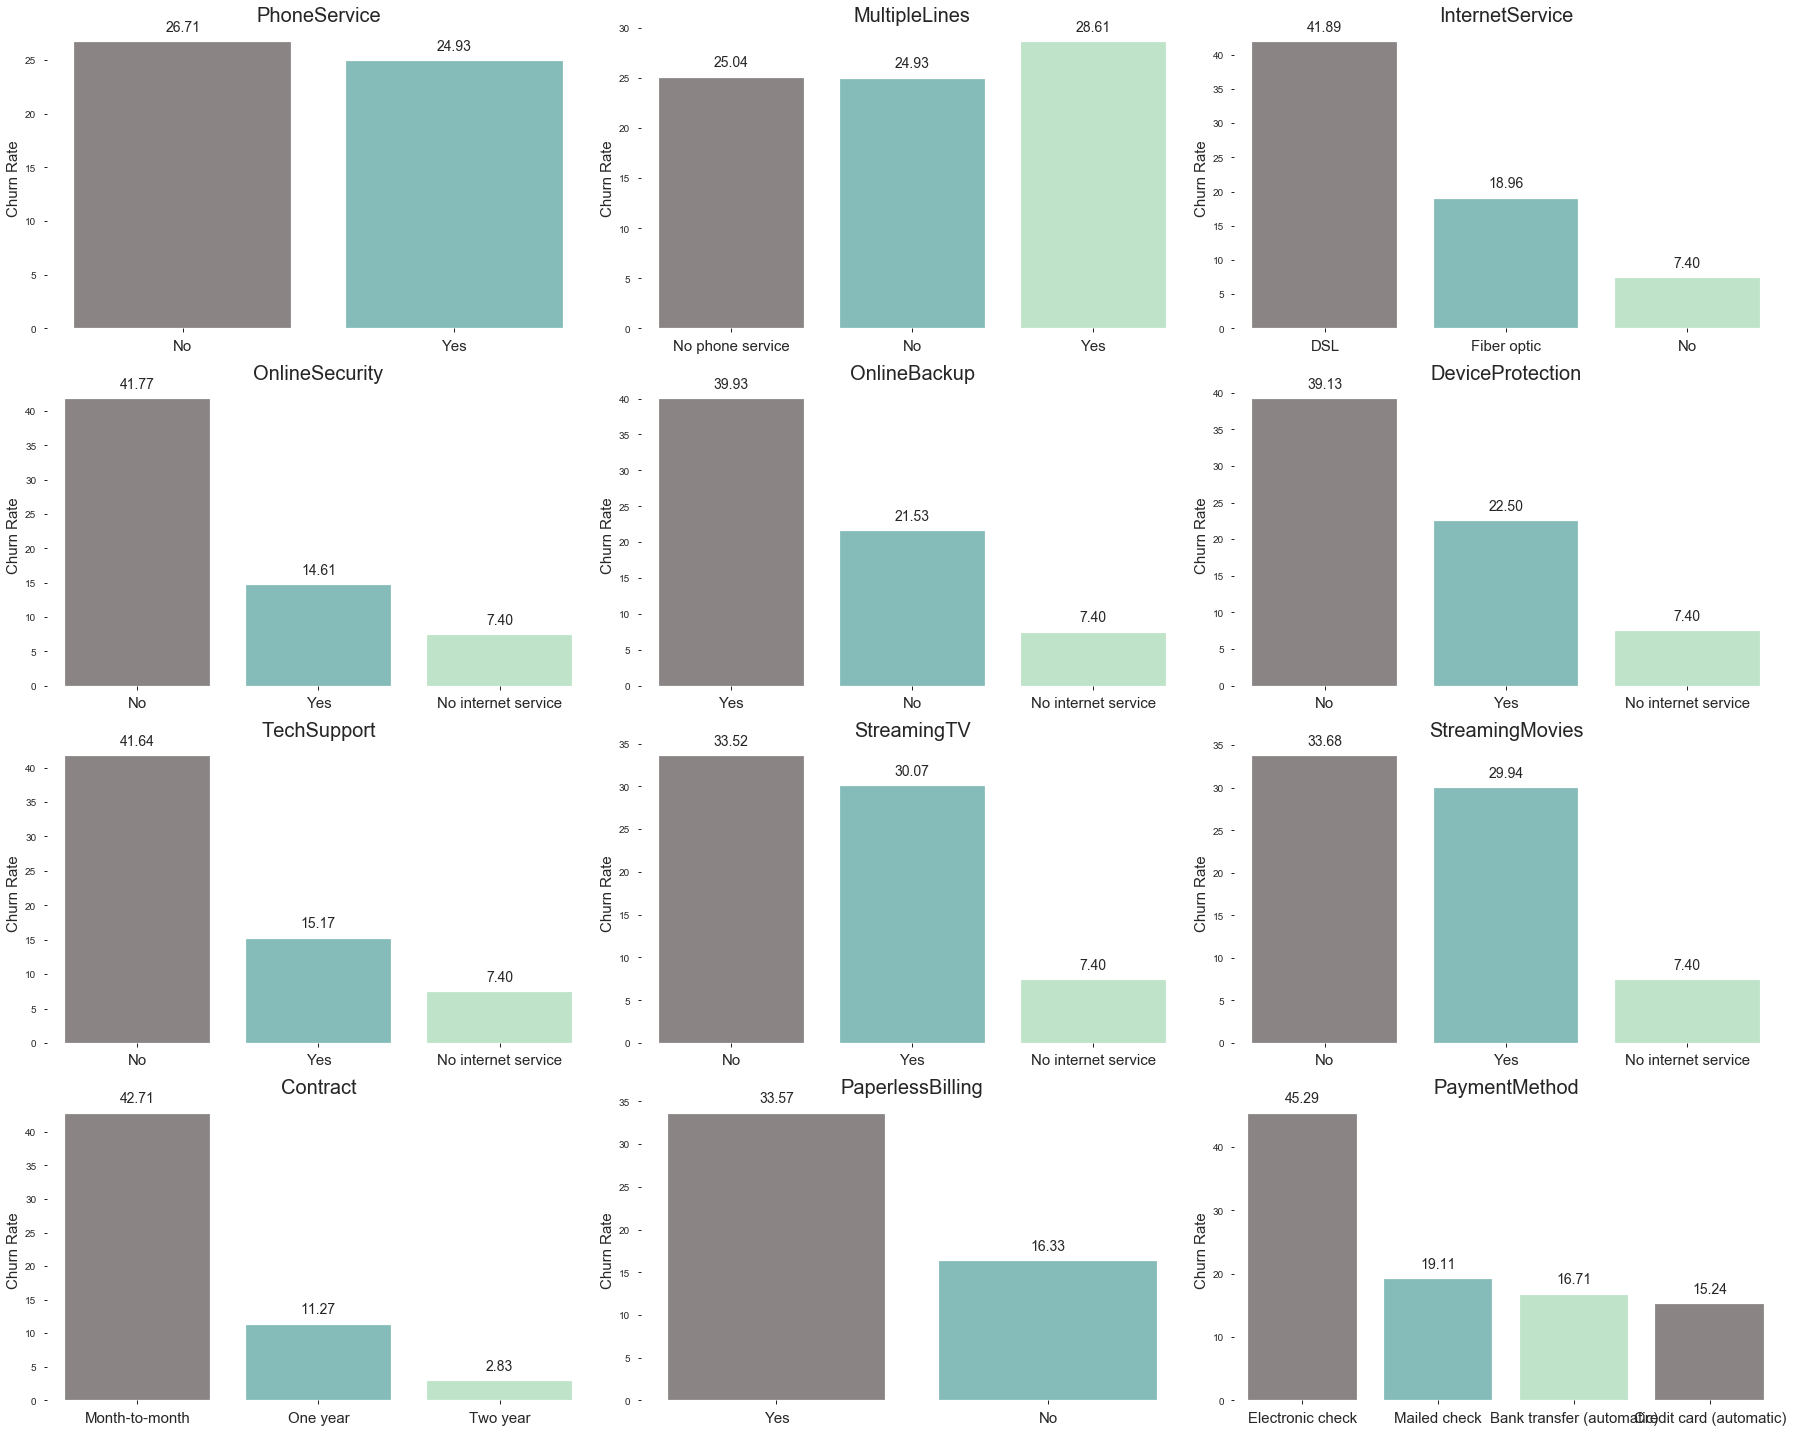

In [424]:
categ_columns = data.select_dtypes('category').columns.drop(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Churn'])

print('Churn Rate by various attributes: \n')

for i in enumerate(categ_columns):

    pylab.subplot(4,3,i[0]+1)
    ax = sns.barplot(y = round(data[data['Churn'] =='Yes'][i[1]].value_counts()*100/data[i[1]].value_counts(),2),x = data[i[1]].unique(), alpha=0.7,  palette = ['#594F4F', '#45ADA8', '#9DE0AD'])
    plt.gcf().set_size_inches(25, 20)
    #plt.setp(ax.get_legend().get_texts(), fontsize='15')
    #plt.setp(ax.get_legend().get_title(), fontsize='17')
    plt.ylabel('Churn Rate', fontsize = 15)
    ax.set_title(i[1], fontsize = 20)
    plt.xticks(fontsize = 15)
    plt.tight_layout()
    # Adding annotations
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', xytext = (0, 15), textcoords = 'offset points', fontsize = 14)

All the groups except from those based on PhoneService and MultipleLines seem to differ in their churn rates.
For example,  `InternetServices` might be a good predictor of churn - there is a clear separation between churn rates among different categories, with **the least churn being observed in clients with no internet service and the highest - with DSL**. There are **a lot of churners among people with no Online Security, no Device Protection and no Tech Support but with Online Backup.** The probability to **churn increases almost twice if the person is paying via electronic check**.The same is true if the person has a month -to month contract, which makes sense since those customers are less likely to be commit to us meaning they aren't sure about our services. There's little we can do about it, only work towards establishing long term relashionship with the customer.

Two top churn factors are `Contract` and `Payment Method` but as a company we can't really influence that. However, we can see that almost half of clients with DSL internet leave us - this is **a clear indication that if we are the providers of DSL service is doesn't work well**. 

We can see that 30% of people who use Streaming services also churn. It is interesting to see whether those are mainly people with DSL connection or Fiber since the latter provides better speed. If that is true we could recommend clients who use streaming and have DSL to switch on Fiber.

In [442]:
# Total users of streaming services
data[(data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')]['InternetService'].value_counts()

Fiber optic    2191
DSL            1308
No                0
Name: InternetService, dtype: int64

In [451]:
# Churn rate among streaming users
round(data[((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')) & (data['Churn'] == 
                        'Yes')]['InternetService'].value_counts()*100/data[(data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 
                        'Yes')]['InternetService'].value_counts(), 2)

Fiber optic    39.94
DSL            14.22
No               NaN
Name: InternetService, dtype: float64

Although there are a lot of streaming users who use DSL (about 50%) their churn rate is actually lower than among those who use Fiber (14% vs. 40%). So it seems that **our streaming customers are churning not because of speed but because of other reasons**.

In [478]:
# Churn rate among all streaming users
print('Churn rate among all streaming users: %s %% - higher than overall churn by 4 percentage points' %round(sum(((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')) & (data['Churn'] == 
                        'Yes'))*100/sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 
                        'Yes')), 2))
print('Total number of streaming users: %s, which is %s %% of all customers' %(sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes')), 
                            round(sum((data['StreamingTV'] == 'Yes') | (data['StreamingMovies'] == 'Yes'))*100/data.shape[0],2)))

Churn rate among all streaming users: 30.32 % - higher than overall churn by 4 percentage points
Total number of streaming users: 3499, which is 49.68 % of all customers


Speaking of complementary services, let's look whether people tend to buy services in bundles, i.e. StreamingTV + StreamingMovies, OnlineSecurity + OnlineBackup.

In [141]:
data.groupby(['StreamingTV', 'StreamingMovies'])['StreamingMovies'].count()

StreamingTV          StreamingMovies    
No                   No                     2018
                     Yes                     792
No internet service  No internet service    1526
Yes                  No                      767
                     Yes                    1940
Name: StreamingMovies, dtype: int64

In [138]:
data.groupby(['OnlineSecurity', 'OnlineBackup'])['OnlineBackup'].count()

OnlineSecurity       OnlineBackup       
No                   No                     2195
                     Yes                    1303
No internet service  No internet service    1526
Yes                  No                      893
                     Yes                    1126
Name: OnlineBackup, dtype: int64

People who own one Streaming Service tend to own another, however, people who have online security not necessarily have online backup.

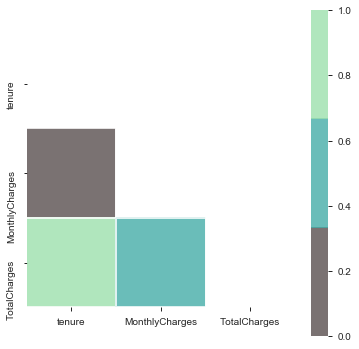

In [480]:
# Checking correlation between numericals
# Correlation of crimes of different types
corr_df = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

fig, ax = plt.subplots(figsize = (6, 6))
sns.heatmap(corr_df, cmap = ['#594F4F', '#45ADA8', '#9DE0AD'], vmin=0, vmax=1, linewidths=.3, square = True, mask = mask, alpha = 0.8)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Some of the numerics are correlated - we will have to check the performance without them or with PCA.

## 2. Skewness <a id=skew>

Before proceeding to machine learning let's take a look at skewness of numerical variables.

In [599]:
from scipy.stats import skew

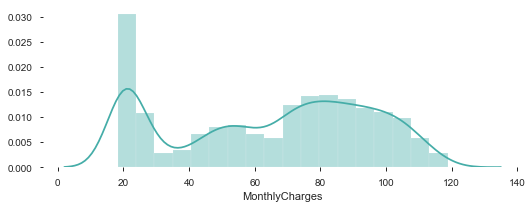

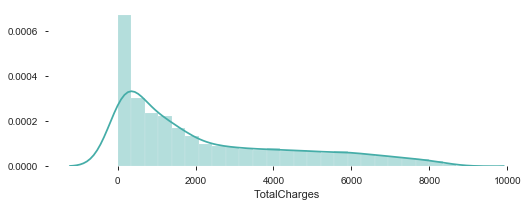

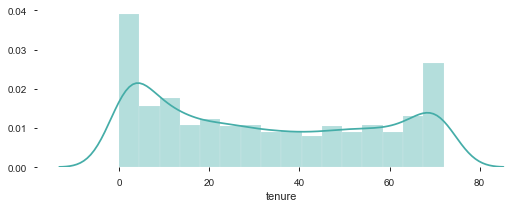

In [481]:
for i in ['MonthlyCharges', 'TotalCharges', 'tenure']:
    a = sns.FacetGrid(data[['MonthlyCharges', 'TotalCharges', 'tenure']], aspect = 2.5, palette = '#45ADA8')
    a.map(sns.distplot,i,color = '#45ADA8')
    plt.show()

The variables look skewed, let's calculate it:

In [223]:
print('Skewness of MonthlyCharges %s' %skew(data['MonthlyCharges']))
print('Skewness of TotalCharges %s' %skew(data['TotalCharges']))
print('Skewness of Tenure %s' %skew(data['tenure']))

Skewness of MonthlyCharges -0.2204774644391769
Skewness of TotalCharges 0.9630294954586066
Skewness of Tenure 0.2394887299846216


In [235]:
# Dealing with TotalCharges
print('Skewness of TotalCharges, sqrt %s' %skew(np.sqrt(data['TotalCharges'])))

Skewness of TotalCharges, sqrt 0.3076546076982302


The square root seems to improve the situation, we'll leave all other variables as they are.

In [597]:
data['TotalCharges'] = np.sqrt(data['TotalCharges'])

## 3. PCA <a id=pca>

Let's see if dimensionality reduction techniques can capture who is churning and tell whether there are certain natural clusters in the database.

In [490]:
pca_pipe = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])
data_prep = pca_pipe.fit_transform(data.drop('Churn', axis = 1))

pca = PCA()
data_pca = pd.DataFrame(pca.fit_transform(data_prep), columns=["PC{}".format(i) for i in range(pca.n_components_)])

In [496]:
# Cumulative explained variance ratio
pca.explained_variance_ratio_.cumsum()

array([0.35813796, 0.5122643 , 0.62352472, 0.68794267, 0.74222345,
       0.79488551, 0.83851125, 0.87744668, 0.90263124, 0.92512225,
       0.94573683, 0.9653706 , 0.97920369, 0.98910354, 0.99396221,
       0.9971409 , 0.99893943, 0.99986935, 1.        , 1.        ])

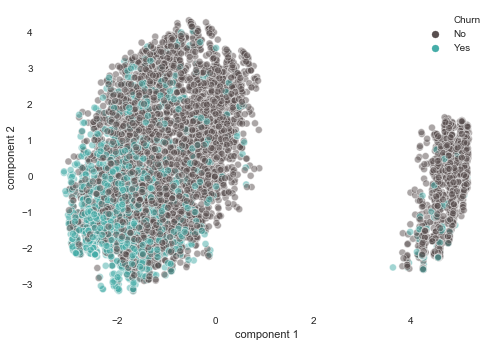

In [493]:
#Plotting the first two components
sns.set_style('white')
sns.scatterplot(data_pca.iloc[:, 0], data_pca.iloc[:, 1],
            hue=data.Churn, alpha=0.5, palette = ['#594F4F', '#45ADA8'])
plt.xlabel('component 1')
plt.ylabel('component 2');

As we can see those components don't seem to distinguish between churn very well. But it also might be because of low cumulative explained variance - only 51%. But it's interesting to see that apparently we have distinguishible groups of customers. Seems like the majority of churn is observed in the main bigger group although it is quite mixed with loyal customers.

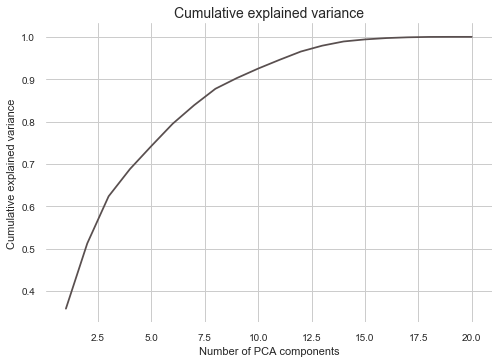

In [495]:
sns.set_style('whitegrid')
sns.lineplot(x = range(1,21), y= pca.explained_variance_ratio_.cumsum(), color = '#594F4F')
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance', fontsize = 14);

We can see that the optimal cutoff for number of components is either 5 or about 8. We will capture either 90.9% or 97.4% of information respectively. However, remember that we are bound to lose all explainability with this technique, so it's not ideal to use it for business purposes (such as tailoring marketing campaigns based on feature importances). 

## 4.Churn Prediction <a id=ml>

Before diving into the Machine Learning it's important to discuss metrics.

Typical metrics would be accuracy, f1 score, precision, recall and roc auc. However, given the imbalanced dataset accuracy is not a suitable metric. Here **we will optimise for f1 score** which balances precision and recall.

Given churn problem, our **False Positives** (people who the model predicted to be churners but in reality are not) **represent money lost on unnecessary marketing campaigns** and our **False Negatives** (people who the model predicted aren't churners but in reality they did churn) **represent people whom we could've retained had we targeted market campaign on them as well**.

However, the main task is to correctly determine churners.

In any way, it's crucial to monitor the changes in the confusion matrix, so that we choose the model most suitable for the business.

In [601]:
# Train-test splitting - given imbalanced dataset it's preferable to take a stratified split

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data, data["Churn"]):
    strat_train = data.loc[train_index]
    strat_test = data.loc[test_index]

class_to_num = {'No':0, 'Yes':1}   
X_train = strat_train.drop(["Churn", "customerID"], axis = 1)
y_train = strat_train.Churn.replace(class_to_num)

X_test = strat_test.drop(["Churn", "customerID"], axis = 1)
y_test = strat_test.Churn.replace(class_to_num)

In [602]:
# Setting an ML pipeline - it's desirable to experiment with categorical encoders (possible options are LabelEncoder, CountEncoder, OneHotEncoder, 
# as wel as scalers - MinMaxScaler, StandardScaler)

transformation_pipeline = Pipeline([('count_encoder', CountEncoder()), 
                    ('scaler', StandardScaler())
                    ])

X_train_prep = transformation_pipeline.fit_transform(X_train)
X_test_prep = transformation_pipeline.fit_transform(X_test) 

## 4.1 Random Forest <a id=rf>

In [ ]:
    'max_depth': [ 5, 6,7, 8],
    'n_estimators': [50, 100,120],
    'criterion': ['gini'], 
    'class_weight': ['balanced'],
    'random_state': [27, 42, 901]
    
}

In [620]:
rf_cl = RandomForestClassifier()

params_grid =  {
    'max_depth': [ 5, 6,7, 8],
    'n_estimators': [35, 30],
    'criterion': ['gini'], 
    'class_weight': ['balanced'],
    'random_state': [27, 42, 901]
    
}

grid_rf = GridSearchCV(rf_cl, cv = StratifiedKFold(5), param_grid = params_grid, n_jobs = -1, verbose = 10, 
                      scoring = 'f1').fit(X_train_prep, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1043s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 115 out of 120 | elapsed:    1.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    1.5s finished


In [621]:
#Best params
grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 7,
 'n_estimators': 35,
 'random_state': 901}

In [622]:
y_test_pred = grid_rf.best_estimator_.predict(X_test_prep)

print('Train performance on Random Forest:', grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest: %s \n'% f1_score(y_test, y_test_pred))
print('Precision: %s'% precision_score(y_test, y_test_pred))
print('Recall: %s'% recall_score(y_test, y_test_pred))

target_class = ['didn\'t churn', 'churn']
print('\n', classification_report(y_test, y_test_pred, target_names = target_class))
print('Confusion matrix, optimised for F1 score \n')
print(pd.DataFrame(confusion_matrix(y_test, y_test_pred),
                 columns=['pred_didn\'t churn', 'pred_churn'], index=['didn\'t churn', 'churn']))

Train performance on Random Forest: 0.7921547745828896
Test performance on Random Forest: 0.6361607142857143 

Precision: 0.5459770114942529
Recall: 0.7620320855614974

               precision    recall  f1-score   support

didn't churn       0.90      0.77      0.83      1035
       churn       0.55      0.76      0.64       374

    accuracy                           0.77      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.77      0.78      1409

Confusion matrix, optimised for F1 score 

              pred_didn't churn  pred_churn
didn't churn                798         237
churn                        89         285


In [623]:
# Predicted churn rate - we are way overestimating our churn rate
(237+285)/(798+89+237+285)

0.37047551454932576

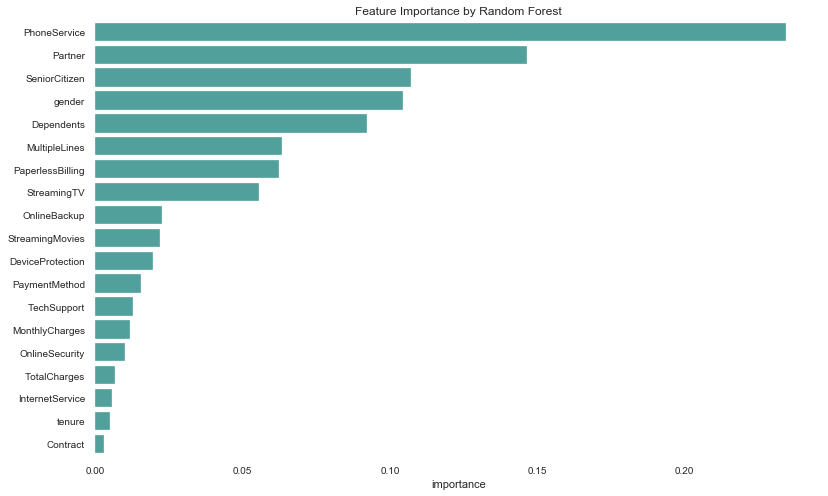

In [624]:
# Feature Importance
feature_names = data.drop(['Churn', 'customerID'], axis = 1).columns
feature_importance = pd.DataFrame({'importance': grid_rf.best_estimator_.feature_importances_}, index=feature_names).sort_values('importance')
sns.set_style("white")

plt.subplots(figsize=(13,8))
sns.barplot(x = feature_importance.importance.sort_values(ascending = False), y = feature_importance.index, palette = ['#45ADA8'])
plt.title('Feature Importance by Random Forest');